In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.utils import shuffle

In [2]:
plt.rcParams['font.family']=['sans-serif']      
plt.rcParams['font.sans-serif']=['SimHei']

In [3]:
# 读取数据保存到 dataframe
data = pd.read_table("data.txt", sep="\s+")
data.head(5)

,airplane,game,icecream,tag
0,40920,8.326976,0.953952,largeDoses
1,14488,7.153469,1.673904,smallDoses
2,26052,1.441871,0.805124,didntLike
3,75136,13.147394,0.428964,didntLike
4,38344,1.669788,0.134296,didntLike


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   airplane  1000 non-null   int64  
 1   game      1000 non-null   float64
 2   icecream  1000 non-null   float64
 3   tag       1000 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 31.4+ KB


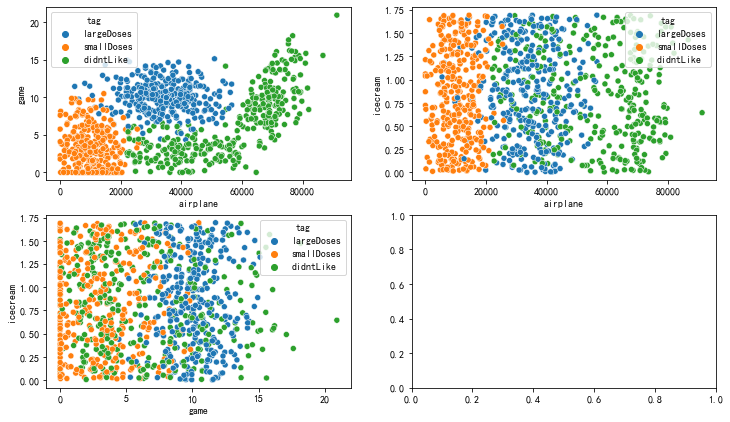

In [5]:
# 查看数据点分布情况
def data_display(data):
    # 创建画布
    fig, axs = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=(12,7))
    sns.scatterplot(x="airplane",y="game",hue="tag",data=data,ax=axs[0][0])
    sns.scatterplot(x="airplane",y="icecream",hue="tag",data=data,ax=axs[0][1])
    sns.scatterplot(x="game",y="icecream",hue="tag",data=data,ax=axs[1][0])

data_display(data)

In [6]:
# 查看 tag
data["tag"].unique()

array(['largeDoses', 'smallDoses', 'didntLike'], dtype=object)

In [7]:
# 将 tag的文本标签转换为 数字标签
myMap = {"largeDoses": 2, "smallDoses": 1, "didntLike": 0}
data["tag"] = data["tag"].map(myMap)
data["tag"].unique()

array([2, 1, 0], dtype=int64)

In [8]:
# 查看样本均衡性
a, b, c = 0, 0, 0
for i in range(1000):
    if data.iloc[i, 3] == 0:
        a += 1
    elif data.iloc[i, 3] == 1:
        b += 1
    else:
        c += 1
print(f"a={a}\nb={b}\nc={c}")

a=342
b=331
c=327


In [9]:
# 特征标准化
data.iloc[:, :3] = (data.iloc[:, :3]-data.iloc[:, :3].mean()
                    )/data.iloc[:, :3].std()

data.head(5)

,airplane,game,icecream,tag
0,0.331766,0.416394,0.245111,2
1,-0.872041,0.139859,1.693010,1
2,-0.345376,-1.206067,-0.054197,0
3,1.890084,1.552315,-0.810694,0
4,0.214445,-1.152359,-1.403303,0


In [10]:
'''
对每个数据进行分类

param: train: 训练集
param: test: 待预测数据
param: labels: train的标签集
param: K: 取前 K 个标签
param: p: 2为欧式距离，1为曼哈顿距离
'''


def classify_series(train, test, labels, K, p):

    # 让测试数据与 train的 shape相同
    test = np.tile(np.array(test), (train.shape[0], 1))

    # 计算差值
    diffMat = test - train

    # 计算距离
    sqDiffMat = diffMat**p
    diffSum = sqDiffMat.sum(axis=1)
    distance = diffSum**(1/p)

    # 获取距离排序后的索引
    idx = distance.argsort()

    # 记录类别次数
    classCount = {}
    for i in range(K):
        label = labels[idx[i]]
        classCount[label] = classCount.get(label, 0) + 1

    # 找到次数最多的类别
    sortClass = sorted(classCount.items(),
                       key=operator.itemgetter(1), reverse=True)
    return sortClass[0][0]

In [11]:
'''
对测试集进行分类

param: train: 训练集
param: test: 测试集
param: train_label: 训练集标签
param: test_label: 测试集标签
param: K: 前 K 个分类

'''


def classify(train, test, train_label, test_label, K):

    # 将dataframe 转换为易于计算的 array
    trains = np.array(train)
    tests = np.array(test)
    train_labels = np.array(train_label)
    test_labels = np.array(test_label)

    # 保存结果
    errorCount = 0

    for i in range(tests.shape[0]):
        temp = []
        pred = classify_series(trains, tests[i], train_labels, 5, 2)
#         print(f"预测类别：{pred}\t真实类别:{test_labels[i]}")
        if pred != test_labels[i]:
            errorCount += 1

    # 计算错误率
    error = round(errorCount / tests.shape[0], 4) * 100
    print(f"错误率：{error}%")
    return error

In [12]:
'''
测试: K=5，前200个数据作测试集

param: data: 数据
param: i: 测试集数量
param: K: K值
'''


def predict(data, i=200,K=5):
    Data = shuffle(data)

    # 前 800个数据作测试集
    test = Data.iloc[:i, :]
    train = Data.iloc[i:, :]

    # 分开特征与标签
    train_data = train.iloc[:, :3]
    train_label = train.iloc[:, 3]
    test_data = test.iloc[:, :3]
    test_label = test.iloc[:, 3]
    
#     a, b, c = 0, 0, 0
#     for i in range(800,1000):
#         if Data.iloc[i, 3] == 0:
#             a += 1
#         elif Data.iloc[i, 3] == 1:
#             b += 1
#         else:
#             c += 1
#     print(f"a={a}\nb={b}\nc={c}\n")
    
    

    classify(train, test, train_label, test_label, K)

In [13]:
# 测试
predict(data,i=800)

错误率：0.13%


In [14]:
'''
可视化：不同的 测试集、训练集划分方式与错误率的关系图

param: data: 数据

'''


def display_train_test(data):
    res = []
    for i in range(100, 990):
        Data = shuffle(data)

        # 前 i 个数据作测试集
        test = Data.iloc[:i, :]
        train = Data.iloc[i:, :]

        # 分开特征与标签
        train_data = train.iloc[:, :3]
        train_label = train.iloc[:, 3]
        test_data = test.iloc[:, :3]
        test_label = test.iloc[:, 3]

        # 分类
        temp = classify(train, test, train_label, test_label, 5)
        res.append(temp)
    
    plt.figure(figsize=(9,6))
    sns.lineplot(x=range(100, 990), y=res)

错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错误率：0.0%
错

错误率：0.21%
错误率：1.58%
错误率：2.21%
错误率：1.26%
错误率：1.3599999999999999%
错误率：0.63%
错误率：0.84%
错误率：4.390000000000001%
错误率：4.590000000000001%
错误率：1.25%
错误率：2.08%
错误率：6.239999999999999%
错误率：2.18%
错误率：3.63%
错误率：2.8000000000000003%
错误率：5.7%
错误率：4.04%
错误率：1.76%
错误率：5.48%
错误率：3.51%
错误率：4.64%
错误率：12.049999999999999%
错误率：4.01%
错误率：4.73%
错误率：8.32%
错误率：2.46%
错误率：13.930000000000001%
错误率：3.0700000000000003%
错误率：3.17%
错误率：3.17%
错误率：10.2%
错误率：4.49%
错误率：23.119999999999997%
错误率：10.38%
错误率：22.759999999999998%
错误率：5.79%
错误率：12.17%
错误率：21.38%
错误率：8.6%
错误率：37.21%


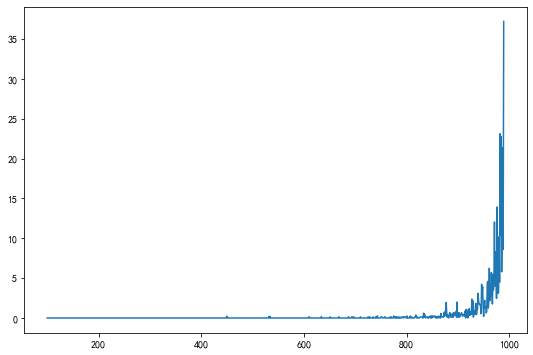

In [15]:
# 测试错误率随训练集数量的变化
# 运行前先注释掉函数 classify（）的 print
display_train_test(data)

In [16]:
'''
可视化：不同的 K 与错误率的关系图

param: data: 数据

'''


def display_K(data):
    res = []
    Data = shuffle(data)

    # 前 800个数据作测试集
    test = Data.iloc[:800, :]
    train = Data.iloc[800:, :]

    # 分开特征与标签
    train_data = train.iloc[:, :3]
    train_label = train.iloc[:, 3]
    test_data = test.iloc[:, :3]
    test_label = test.iloc[:, 3]

    for k in range(1, 10):
        # 分类
        temp = classify(train, test, train_label, test_label, k)
        res.append(temp)

    plt.figure(figsize=(9, 6))
    sns.lineplot(x=range(1, 10), y=res)

错误率：0.13%
错误率：0.13%
错误率：0.13%
错误率：0.13%
错误率：0.13%
错误率：0.13%
错误率：0.13%
错误率：0.13%
错误率：0.13%


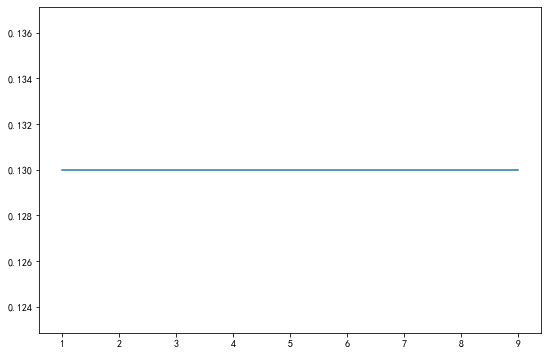

In [17]:
# 测试错误率随 K的变化
display_K(data)